In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot stylin

from itertools import product

In [501]:
df_1 = pd.read_csv('Data/my/Questions_Answers.csv')
df_2 = pd.read_csv('Data/my/User_Question_Answer.csv', low_memory=False)

In [502]:
# Context manager to temporarily set options in the with statement context
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

## Preprocessing

In [564]:
df_2.head()

,user_id,question_id,answer_id,datetimestamp
0,10109,21045,60570,2018-09-06 16:18:02
1,10135,21045,60571,2018-09-06 15:20:57
2,10237,21045,60571,2018-09-06 13:30:05
3,10261,21045,60570,2018-09-06 14:40:45
4,10268,21045,60571,2018-09-06 15:06:17


In [504]:
len(df_2), df_2.user_id.nunique()

(512410, 7243)

In [505]:
# Check if any row contains a null
df_2[df_2['datetimestamp'].isnull()]

,user_id,question_id,answer_id,datetimestamp
119871,82778,6,2018-09-12 19:09:06,NaN


In [506]:
df_2[df_2['datetimestamp'] == '2018-09-17 14:56:5,61898,2018-09-15 21:21:00"']

,user_id,question_id,answer_id,datetimestamp
291489,92579,21545,61865,"2018-09-17 14:56:5,61898,2018-09-15 21:21:00"""


In [507]:
df_2[df_2['datetimestamp'] == '2018-09-18 13:0:\r\n74517,21562,61910,2018-09-16 07:01:52"']

,user_id,question_id,answer_id,datetimestamp
294320,75880,21559,61902,"2018-09-18 13:0:\r\n74517,21562,61910,2018-09-..."


In [508]:
# Dropped the above corrupt rows
df_2.drop(index=119871, inplace=True)
df_2.drop(index=291489, inplace=True)
df_2.drop(index=294320, inplace=True)

In [509]:
# Convert datetimestamp from object type to datetime type
df_2['datetimestamp'] = pd.to_datetime(df_2['datetimestamp'])

In [510]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512407 entries, 0 to 512409
Data columns (total 4 columns):
user_id          512407 non-null int64
question_id      512407 non-null int64
answer_id        509801 non-null object
datetimestamp    512407 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 19.5+ MB


In [511]:
# Dropped rows in null answers for now, although in real model this might not be the right approach
df_2.dropna(inplace=True)

In [512]:
df_2.answer_id = df_2.answer_id.astype('int64')

In [513]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509801 entries, 0 to 512409
Data columns (total 4 columns):
user_id          509801 non-null int64
question_id      509801 non-null int64
answer_id        509801 non-null int64
datetimestamp    509801 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 19.4 MB


### Create Matrix of users

In [514]:
df_2.user_id.nunique()

7242

In [515]:
df_2.question_id.nunique()

183

In [516]:
# Not all users are associated with all questions
len(df_2[df_2.question_id == 21045]), len(df_2[df_2.question_id == 21104]), len(df_2[df_2.question_id == 21108])

(3000, 2000, 2724)

In [517]:
# I need to create a matrix of the below size
7242*183

1325286

In [518]:
# We need to create a matrix of users vs every question and fill with nulls the missing answers
matrix = []
for i in df_2.user_id.unique():
    ques_unique = df_2.question_id.unique()
    matrix.append(np.array(list(product(*[ [i], ques_unique]))))

In [519]:
matrix = pd.DataFrame(np.vstack(matrix), columns = ['user_id', 'question_id'])

In [520]:
matrix.shape

(1325286, 2)

In [521]:
# Merge with df_2 to return the answers
matrix = matrix.merge(df_2, on =['user_id', 'question_id'], how='left')

Sanity cheking that the matrix is correct

In [522]:
matrix.head()

,user_id,question_id,answer_id,datetimestamp
0,10109,21045,60570.0,2018-09-06 16:18:02
1,10109,21104,NaN,NaT
2,10109,21106,NaN,NaT
3,10109,21107,NaN,NaT
4,10109,21108,NaN,NaT


In [523]:
# Same value for answrs and timestamp
matrix.isnull().sum()

user_id               0
question_id           0
answer_id        815485
datetimestamp    815485
dtype: int64

In [524]:
# SANITY CHECKER
df_2[(df_2.user_id == 10109) & (df_2.question_id == 21045)]

,user_id,question_id,answer_id,datetimestamp
0,10109,21045,60570,2018-09-06 16:18:02


In [525]:
# SANITY CHECKER
matrix[(matrix.user_id == 10109) & (matrix.question_id == 21045)]

,user_id,question_id,answer_id,datetimestamp
0,10109,21045,60570.0,2018-09-06 16:18:02


##### Getting the question features into our matrix

In [527]:
df_1.shape

(623, 17)

In [528]:
df_1.head()

,question_id,title,start_age,end_age,sex_id,category_id,nb_targets,nb_points,created_at,updated_at,topic_id,prefered_lang,rank,Total_Number_of_Answers,answer_id,description,Number_Of_Answers
0,21045,Are you trying to lose weight?,10,80,0.0,7,3000,1,2018-09-06 01:23:42,2018-09-06 15:12:03,0,0.0,0,3000,60570,Yes,1943
1,21045,Are you trying to lose weight?,10,80,0.0,7,3000,1,2018-09-06 01:23:42,2018-09-06 15:12:03,0,0.0,0,3000,60571,No,1057
2,21104,Which water brand do you prefer?,10,80,0.0,12,2000,1,2018-09-07 12:51:52,2018-09-07 12:55:01,0,NaN,1,2000,60724,Sohat,698
3,21104,Which water brand do you prefer?,10,80,0.0,12,2000,1,2018-09-07 12:51:52,2018-09-07 12:55:01,0,NaN,1,2000,60725,Rim,337
4,21104,Which water brand do you prefer?,10,80,0.0,12,2000,1,2018-09-07 12:51:52,2018-09-07 12:55:01,0,NaN,1,2000,60726,Sannine,139


In [529]:
df_1.drop('prefered_lang', axis=1, inplace=True)

In [530]:
# Drop the rows with desctiption empty
df_1.dropna(inplace=True)

In [531]:
# Create a unique answer 'Yes'
df_1.description.replace('Yes ', 'Yes', inplace=True)

In [532]:
useful = df_1[['answer_id', 'description']].copy()

In [533]:
# Extract the text value of the answer rather than the code because every code is unique to each questions and doesnt allow for lots of interpreation
temp = matrix.merge(useful, on = 'answer_id', how='left')

In [534]:
temp.drop('answer_id',axis=1, inplace=True)

In [535]:
temp.columns

Index(['user_id', 'question_id', 'datetimestamp', 'description'], dtype='object')

In [536]:
temp.shape

(1325286, 4)

In [537]:
temp.head()

,user_id,question_id,datetimestamp,description
0,10109,21045,2018-09-06 16:18:02,Yes
1,10109,21104,NaT,NaN
2,10109,21106,NaT,NaN
3,10109,21107,NaT,NaN
4,10109,21108,NaT,NaN


In [538]:
# We need extract more features from df_1
useful_2 = df_1[['question_id', 'title', 'sex_id', 'category_id', 'nb_points', 'created_at']]

# Make sure to drop duplicate question as answers are no more visible
useful_2.drop_duplicates(inplace=True)

temp = temp.merge(useful_2, on = 'question_id')

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Sanity Checker to make sure that every user has a list of all questions and answers

In [539]:
len(temp[temp.user_id == 89])

177

In [540]:
temp.drop('question_id',axis=1, inplace=True)

In [541]:
temp.columns

Index(['user_id', 'datetimestamp', 'description', 'title', 'sex_id',
       'category_id', 'nb_points', 'created_at'],
      dtype='object')

In [542]:
temp.rename(index=str, columns={"description": "Answer", "title": "Question", 'datetimestamp':'respond_time'}, inplace=True)

In [543]:
temp.head()

,user_id,respond_time,Answer,Question,sex_id,category_id,nb_points,created_at
0,10109,2018-09-06 16:18:02,Yes,Are you trying to lose weight?,0.0,7,1,2018-09-06 01:23:42
1,10135,2018-09-06 15:20:57,No,Are you trying to lose weight?,0.0,7,1,2018-09-06 01:23:42
2,10237,2018-09-06 13:30:05,No,Are you trying to lose weight?,0.0,7,1,2018-09-06 01:23:42
3,10261,2018-09-06 14:40:45,Yes,Are you trying to lose weight?,0.0,7,1,2018-09-06 01:23:42
4,10268,2018-09-06 15:06:17,No,Are you trying to lose weight?,0.0,7,1,2018-09-06 01:23:42


In [544]:
# Convert created_at from object type to datetime type
temp['created_at'] = pd.to_datetime(temp['created_at'])
temp['respond_time'] = pd.to_datetime(temp['respond_time'])

# Convert feature type to category
temp.Question = temp.Question.astype('category')
temp.Answer = temp.Answer.astype('category')
temp.category_id = temp.category_id.astype('category')
temp.sex_id = temp.sex_id.astype('category')

In [545]:
temp.dtypes

user_id                  int64
respond_time    datetime64[ns]
Answer                category
Question              category
sex_id                category
category_id           category
nb_points                int64
created_at      datetime64[ns]
dtype: object

In [550]:
temp.isnull().sum()

user_id              0
respond_time    797033
Answer          797033
Question             0
sex_id               0
category_id          0
nb_points            0
created_at           0
dtype: int64

#### Now, we have a dataframe to work with

## Feature Engineering

#### 1. Time difference between question and answer by user

In [552]:
df = temp.copy()
df.head()

,user_id,respond_time,Answer,Question,sex_id,category_id,nb_points,created_at
0,10109,2018-09-06 16:18:02,Yes,Are you trying to lose weight?,0.0,7,1,2018-09-06 01:23:42
1,10135,2018-09-06 15:20:57,No,Are you trying to lose weight?,0.0,7,1,2018-09-06 01:23:42
2,10237,2018-09-06 13:30:05,No,Are you trying to lose weight?,0.0,7,1,2018-09-06 01:23:42
3,10261,2018-09-06 14:40:45,Yes,Are you trying to lose weight?,0.0,7,1,2018-09-06 01:23:42
4,10268,2018-09-06 15:06:17,No,Are you trying to lose weight?,0.0,7,1,2018-09-06 01:23:42


In [553]:
df['time_diff'] = (df['created_at'] - df['respond_time']).astype('timedelta64[h]')

In [556]:
df['time_diff'] = df['time_diff'].abs()

In [569]:
# Grouping by response time to question on app
# Worst 10 Users in response time
df.groupby('user_id').time_diff.mean().sort_values(ascending=False).head(10)

user_id
17067     301.571429
105961    290.500000
100494    290.000000
27546     270.000000
12468     235.333333
109201    234.200000
87931     232.428571
100593    199.000000
89703     198.166667
89745     195.916667
Name: time_diff, dtype: float64

In [570]:
# Best 10 Users in response time
df.groupby('user_id').time_diff.mean().sort_values(ascending=False).tail(10)

user_id
105841    1.0
107376    1.0
108326    1.0
108327    1.0
94696     1.0
108328    1.0
108330    1.0
101277    1.0
107673    NaN
108853    NaN
Name: time_diff, dtype: float64

#### We can see that users 107673 and 108853 has null values because they answered one question which turned out to be a question with all missign values in which I dropped earlier

# Treating every question as a feature

In [2]:
data = pd.read_csv('Data/my/QAID.csv')
qa = pd.read_csv('Data/my/Questions_Answers.csv')

In [3]:
data.head()

,user_id,q_9423,q_9328,q_9326,q_9431,q_9429,q_9435,q_9428,q_9434,q_9433,...,q_8179,q_6119,q_7903,q_8632,q_7420,q_7708,q_7785,q_7803,q_8005,q_8408
0,89,29239,0,0,29264,29258,29284,29253,29278,29276,...,0,0,0,26778,0,0,0,0,0,0
1,107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,173,29239,0,0,29268,29259,29284,29252,29278,29275,...,0,0,0,0,0,0,0,0,0,0
3,183,29239,0,0,29268,29257,29285,29255,29278,29275,...,0,0,0,0,0,0,0,0,0,0
4,10109,29239,0,0,29268,29259,29281,29252,29278,29273,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data.shape

(4513, 420)

In [611]:
qa.columns

Index(['question_id', 'title', 'start_age', 'end_age', 'sex_id', 'category_id',
       'nb_targets', 'nb_points', 'created_at', 'updated_at', 'topic_id',
       'prefered_lang', 'rank', 'Total_Number_of_Answers', 'answer_id',
       'description', 'Number_Of_Answers'],
      dtype='object')

In [579]:
data.user_id.nunique()

4513

### Since this is categorical data we are working with, keeping the answerid as a numeric variable will fool the clustering algorithm into measuring the distance although there is no real distance implied in these numbers

In [609]:
temp = qa[['answer_id', 'description']]

In [591]:
# mapper = dict(zip(qa.answer_id.values, qa.description.values))

In [610]:
temp.head()

,answer_id,description
0,60570,Yes
1,60571,No
2,60724,Sohat
3,60725,Rim
4,60726,Sannine


In [603]:
data['q_9434'] = qa['answer_id']

In [605]:
data['q_9434']

0       60570.0
1       60571.0
2       60724.0
3       60725.0
4       60726.0
5       60727.0
6       60728.0
7       60732.0
8       60733.0
9       60734.0
10      60735.0
11      60750.0
12      60736.0
13      60737.0
14      60738.0
15      60739.0
16      60740.0
17      60741.0
18      60742.0
19      60743.0
20      60744.0
21      60745.0
22      60746.0
23      60747.0
24      60748.0
25      60749.0
26      60751.0
27      60752.0
28      60753.0
29      60754.0
         ...   
4483        NaN
4484        NaN
4485        NaN
4486        NaN
4487        NaN
4488        NaN
4489        NaN
4490        NaN
4491        NaN
4492        NaN
4493        NaN
4494        NaN
4495        NaN
4496        NaN
4497        NaN
4498        NaN
4499        NaN
4500        NaN
4501        NaN
4502        NaN
4503        NaN
4504        NaN
4505        NaN
4506        NaN
4507        NaN
4508        NaN
4509        NaN
4510        NaN
4511        NaN
4512        NaN
Name: q_9434, Length: 45

In [ ]:
# Convert the answerid to value then label encode as these are categorical data


In [7]:
# data.isnull().sum()

The standard k-means performs poorly in case of categorical data since in the sample space is discrete. The cost function defined by k-means computes the Euclidean Distance (or something similar) which is relevant only for continuous variables. Instead of computing the Euclidean distance, one could use the Hammer Distance (for categorical) or Gower Distance (for mixed). Instead of computing the mean, one can compute the mode. The most occurring value of a nominal variable is used as its representative (centers of cluster). Such a cost function is used in a variation of k-means called k-modes. Modes are analogous to centroids in k-means.

If you are using python then you could probably use this package.

In [9]:
data.q_9423.value_counts()

29239    1842
0        1252
29237     757
29238     662
Name: q_9423, dtype: int64

In [10]:
data.q_9328.value_counts()

28939    2129
0        1943
28942     202
28940     149
28941      90
Name: q_9328, dtype: int64

In [11]:
data.q_9328.factorize()[0]

array([0, 0, 0, ..., 1, 3, 0], dtype=int64)

1. Take the answers and replace code with answers
2. Then label encode them, this way the answers will look similar along the different questions

https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data/24#24
https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data/24#24
https://arxiv.org/ftp/cs/papers/0603/0603120.pdf


# Creating a feature from every answer code

In [2]:
df = pd.read_csv('Data/my/User_Question_Answer.csv', low_memory=False)

In [3]:
df_q = pd.read_csv('Data/my/Questions_Answers.csv')

In [4]:
df = df[['user_id', 'answer_id']].copy()

In [5]:
matrix = pd.get_dummies(df,  'answer_id')

In [6]:
matrix.drop('answer_id_2018-09-12 19:09:06', axis=1, inplace=True)

In [7]:
matrix.user_id.nunique()

7243

In [8]:
data = matrix.groupby('user_id')[matrix.columns[1:]].sum().reset_index()

In [9]:
# Context manager to temporarily set options in the with statement context
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [10]:
display_all(data.head())

,user_id,answer_id_60570,answer_id_60571,answer_id_60724,answer_id_60725,answer_id_60726,answer_id_60727,answer_id_60728,answer_id_60732,answer_id_60733,answer_id_60734,answer_id_60735,answer_id_60736,answer_id_60737,answer_id_60738,answer_id_60739,answer_id_60740,answer_id_60741,answer_id_60742,answer_id_60743,answer_id_60744,answer_id_60745,answer_id_60746,answer_id_60747,answer_id_60748,answer_id_60749,answer_id_60750,answer_id_60751,answer_id_60752,answer_id_60753,answer_id_60754,answer_id_60755,answer_id_60756,answer_id_60757,answer_id_60758,answer_id_60759,answer_id_60760,answer_id_60761,answer_id_60762,answer_id_60763,answer_id_60764,answer_id_60765,answer_id_60766,answer_id_60767,answer_id_60768,answer_id_60769,answer_id_60770,answer_id_60771,answer_id_60772,answer_id_60773,answer_id_60774,answer_id_60775,answer_id_60776,answer_id_60779,answer_id_60780,answer_id_60790,answer_id_60791,answer_id_60792,answer_id_60793,answer_id_60800,answer_id_60801,answer_id_60802,answer_id_60803,answer_id_60807,answer_id_60808,answer_id_60809,answer_id_60810,answer_id_60815,answer_id_60816,answer_id_60821,answer_id_60822,answer_id_60828,answer_id_60829,answer_id_60834,answer_id_60835,answer_id_60836,answer_id_60837,answer_id_60842,answer_id_60843,answer_id_60848,answer_id_60849,answer_id_60854,answer_id_60855,answer_id_60860,answer_id_60861,answer_id_60862,answer_id_60863,answer_id_60868,answer_id_60869,answer_id_61511,answer_id_61512,answer_id_61516,answer_id_61517,answer_id_61518,answer_id_61519,answer_id_61520,answer_id_61521,answer_id_61524,answer_id_61525,answer_id_61526,answer_id_61527,answer_id_61528,answer_id_61529,answer_id_61530,answer_id_61531,answer_id_61532,answer_id_61533,answer_id_61534,answer_id_61535,answer_id_61539,answer_id_61540,answer_id_61541,answer_id_61542,answer_id_61588,answer_id_61589,answer_id_61590,answer_id_61591,answer_id_61601,answer_id_61602,answer_id_61607,answer_id_61608,answer_id_61609,answer_id_61610,answer_id_61627,answer_id_61628,answer_id_61629,answer_id_61630,answer_id_61637,answer_id_61638,answer_id_61657,answer_id_61661,answer_id_61662,answer_id_61663,answer_id_61664,answer_id_61668,answer_id_61669,answer_id_61670,answer_id_61671,answer_id_61672,answer_id_61673,answer_id_61674,answer_id_61675,answer_id_61676,answer_id_61677,answer_id_61678,answer_id_61679,answer_id_61680,answer_id_61685,answer_id_61686,answer_id_61687,answer_id_61688,answer_id_61694,answer_id_61695,answer_id_61696,answer_id_61697,answer_id_61698,answer_id_61699,answer_id_61700,answer_id_61701,answer_id_61702,answer_id_61703,answer_id_61704,answer_id_61705,answer_id_61706,answer_id_61707,answer_id_61749,answer_id_61750,answer_id_61751,answer_id_61752,answer_id_61753,answer_id_61754,answer_id_61759,answer_id_61760,answer_id_61761,answer_id_61762,answer_id_61763,answer_id_61764,answer_id_61765,answer_id_61766,answer_id_61767,answer_id_61768,answer_id_61769,answer_id_61770,answer_id_61771,answer_id_61772,answer_id_61773,answer_id_61774,answer_id_61775,answer_id_61776,answer_id_61777,answer_id_61782,answer_id_61783,answer_id_61784,answer_id_61785,answer_id_61786,answer_id_61787,answer_id_61788,answer_id_61789,answer_id_61790,answer_id_61791,answer_id_61794,answer_id_61795,answer_id_61798,answer_id_61799,answer_id_61800,answer_id_61801,answer_id_61804,answer_id_61805,answer_id_61806,answer_id_61809,answer_id_61810,answer_id_61811,answer_id_61812,answer_id_61813,answer_id_61814,answer_id_61815,answer_id_61816,answer_id_61817,answer_id_61818,answer_id_61824,answer_id_61825,answer_id_61831,answer_id_61832,answer_id_61833,answer_id_61834,answer_id_61835,answer_id_61836,answer_id_61837,answer_id_61838,answer_id_61839,answer_id_61840,answer_id_61841,answer_id_61842,answer_id_61843,answer_id_61844,answer_id_61847,answer_id_61848,answer_id_61851,answer_id_61852,answer_id_61853,answer_id_61854,answer_id_61855,answer_id_61856,answer_id_61857,answer_id_61858,answer_id_61859,answer_id_61860,answer_id_61861,answer_id_61862,answer_id_61863,answer_

In [11]:
# Sanity Check
df[df.user_id == 89].answer_id.values

array(['60725', '60736', '60746', '60761', '60763', '60767', '60771',
       '60775', '60780', '60791', '60803', '60810', '60816', '60821',
       '60829', '60837', '60842', '60855', '60861', '60868', '61608',
       '61610', '61630', '61637', '61662', '61678', '61686', '61688',
       '61698', '61754', '61786', '61788', '61847', '61851', '61860',
       '61918', '61923', '61925', '61930', '61949', '62000', '62052'],
      dtype=object)

In [12]:
data.columns[data.iloc[0]>0]

Index(['user_id', 'answer_id_60725', 'answer_id_60736', 'answer_id_60746',
       'answer_id_60761', 'answer_id_60763', 'answer_id_60767',
       'answer_id_60771', 'answer_id_60775', 'answer_id_60780',
       'answer_id_60791', 'answer_id_60803', 'answer_id_60810',
       'answer_id_60816', 'answer_id_60821', 'answer_id_60829',
       'answer_id_60837', 'answer_id_60842', 'answer_id_60855',
       'answer_id_60861', 'answer_id_60868', 'answer_id_61608',
       'answer_id_61610', 'answer_id_61630', 'answer_id_61637',
       'answer_id_61662', 'answer_id_61678', 'answer_id_61686',
       'answer_id_61688', 'answer_id_61698', 'answer_id_61754',
       'answer_id_61786', 'answer_id_61788', 'answer_id_61847',
       'answer_id_61851', 'answer_id_61860', 'answer_id_61918',
       'answer_id_61923', 'answer_id_61925', 'answer_id_61930',
       'answer_id_61949', 'answer_id_62000', 'answer_id_62052'],
      dtype='object')

After we have the data in the right form, we can have a premilinary model to train

## What we need is cluster to responders into segments based on their answers:
To do so we will implement a K-Means clustering algorithm on the above data. This algorithm simply finds the center mass of the points based on the number of centers we chose and uses Eculidea distance to measure each point to the new centroid or what is the most similar to each centroid

## Feature Transformation
In this section you will use principal component analysis (PCA) to reduce the number of features and to make sense of this high dimensional data

In [36]:
data.head()

,user_id,answer_id_60570,answer_id_60571,answer_id_60724,answer_id_60725,answer_id_60726,answer_id_60727,answer_id_60728,answer_id_60732,answer_id_60733,...,answer_id_62302,answer_id_62303,answer_id_62304,answer_id_62305,answer_id_62306,answer_id_62307,answer_id_62308,answer_id_62309,answer_id_62310,answer_id_62311
0,89,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,107,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,173,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,183,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10109,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [37]:
data.set_index('user_id', inplace=True)

In [38]:
data.head()

,answer_id_60570,answer_id_60571,answer_id_60724,answer_id_60725,answer_id_60726,answer_id_60727,answer_id_60728,answer_id_60732,answer_id_60733,answer_id_60734,...,answer_id_62302,answer_id_62303,answer_id_62304,answer_id_62305,answer_id_62306,answer_id_62307,answer_id_62308,answer_id_62309,answer_id_62310,answer_id_62311
user_id,,,,,,,,,,,,,,,,,,,,,
89,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10109,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [56]:
data.shape

(7243, 489)

In [48]:
from sklearn.decomposition import PCA

# PCA by fitting the data with only two dimensions
pca = PCA(n_components=2)
pca.fit(data)

# Transform the data using the PCA fit above
reduced_data = pca.transform(data)

# Create a DataFrame for the reduced data
pca_df = pd.DataFrame.from_records(reduced_data, columns = ['PC-1', 'PC-2'])
pca_df.head()

,PC-1,PC-2
0,-1.679262,-0.127104
1,-1.330687,-0.766584
2,-0.894045,0.286692
3,-2.078110,-0.737747
4,-2.639861,0.429728


## K-mean clustering 

In [19]:
# Import algorithm from Scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [43]:
#Loop through different cluster numbers to see which gives thehighest silhouette score

range_n_clusters = [2, 3, 5]

for n_classes in range_n_clusters:
    kmeans = KMeans(n_clusters=n_classes, random_state=0, n_jobs=-1)
    # Fit it to the data
    k_fit = kmeans.fit(data)
    # Predict the cluster for each data point
    pred = kmeans.predict(data)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    silhouette_avg = round(silhouette_score(data, pred), 3)
    print("For n_clusters", n_classes, "the average silhouette_score is: ", silhouette_avg)

For n_clusters 2 the average silhouette_score is:  0.124
For n_clusters 3 the average silhouette_score is:  0.121
For n_clusters 5 the average silhouette_score is:  0.053


Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

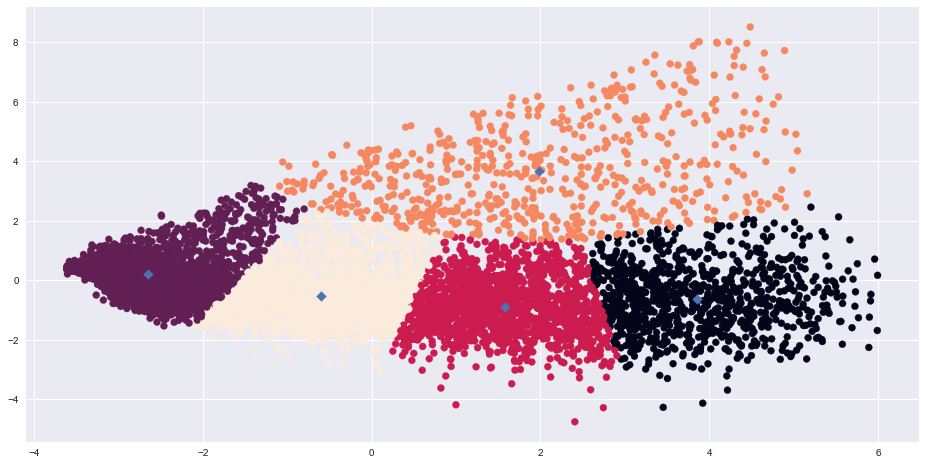

In [55]:
kmeans_5 = KMeans(n_clusters=5, random_state=0, n_jobs=-1)

kmeans_5.fit(pca_df)
y_kmeans = kmeans_5.predict(pca_df)
centers_kmeans = kmeans_5.cluster_centers_
center = pd.DataFrame.from_records(centers_kmeans, columns = ['A', 'B'])

fig=plt.figure(figsize=(16, 8))
plt.scatter(pca_df['PC-1'], pca_df['PC-2'], c = y_kmeans)
plt.scatter(center.A, center.B, marker = 'D')

This is how the 489 users are segmented based on their answers.
This is far from finished as we can explore more models, add more features related to the user and explore with some feature engineering